## GARCH Model

### Description:

In this notebook we will implement the code for a **GARCH Model** in order to make Financial **Time Series Forecasting**.

Most of the notebook will be the same as in the **ARIMA** notebook, since the pre-process the the series must have is quite similar.

As explained in the **SeriesAnalysis** notebook, this notebook will use the results already obtained in **Series Analysis**, so that the focus can be only on the Model itself.

### GARCH Model Brief Introduction

This model is almost the same as the ARIMA Model, with the only difference being the use of an GARCH Model to predict the ARIMA Model Variance at each time step, being a function of the ARIMA Residuals. We basically compute these 2 models, first training the ARIMA and then the GARCH on the residuals of the first and sum their predictions. 

In [6]:
### Some useful functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import sklearn.metrics

np.random.seed(0)

import warnings
warnings.filterwarnings(action='ignore')

<module 'warnings' from 'C:\\Users\\matno\\miniconda3\\lib\\warnings.py'>

### Some useful functions


In [7]:
#Read and filter data from csv files, as well as handle missing values
def read_filter(path,index,value,freq):
    df = pd.read_csv(path)
    series = df.loc[:,[index,value]]
    series.set_index(index,inplace=True)
    series.index=pd.to_datetime(series.index)
    series = series.asfreq('d')
    series = series.interpolate()
    return series

def plot_2_series(real,model,error_value,title,xlabel="Time",ylabel="Values"):
    fig = plt.figure()

    #plotting the series
    plt.plot(real)
    plt.plot(model)

    #Title and lables
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)

    #Text displaying the RMSE
    text = "RMSE: %.4f" %error_value
    bottom = np.minimum(model.min(),real.min())
    plt.text(x=plt.xlim()[0],y=bottom,s=text)
    plt.legend(['Original Series','Predicted'])
    plt.show()
    return
    
    
# differentiate the series
def diff(series,t):
    for i in range(t):
        series = series - series.shift(1)
        series = series.dropna()
    
    return series

#train test split
def train_test(serie,numtest):
    train = serie.iloc[0:len(serie)-numtest]
    test = serie.iloc[len(serie)-numtest:]    
    return train, test
    
#Compute some error metrics
def errors(actual, predicted):
    me = np.mean(predicted.values - actual.values)  # ME
    mae = sklearn.metrics.median_absolute_error(actual,predicted)    # MAE
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(actual,predicted))  # RMSE
    
    errors = [['ME',me],['MAE',mae],['RMSE',rmse]]
    
    errors = pd.DataFrame(errors,columns=['Error','Value'])
    return errors



In [8]:
#Importing the dataset and making some changes
USD_CAD_serie = read_filter('../data/CAD=X.csv','Date','Adj Close','w')
USD_BRL_serie = read_filter('../data/BRL=X.csv','Date','Adj Close','w')
AmericanAirlines_serie = read_filter('../data/AAL2010_2019.csv','Date','Adj Close','w')

#differentiating the series
USD_CAD_serie_diff1 = diff(USD_CAD_serie,1)
USD_BRL_serie_diff1 = diff(USD_BRL_serie,1)
AmericanAirlines_serie_diff1 = diff(AmericanAirlines_serie,1)

## Train and Test Split

In [9]:
largest_horizon = 12 # 12 weeks, 3 months

train_American_diff1, test_American_diff1 = train_test(AmericanAirlines_serie_diff1,12)
train_USD_CAD_diff1, test_USD_CAD_diff1 = train_test(USD_CAD_serie_diff1,12)
train_USD_BRL_diff1, test_USD_BRL_diff1 = train_test(USD_BRL_serie_diff1,12)

## Fit ARIMA+GARCH Model

In [10]:
#Training an ARIMA MODEL for each series
arima_American_diff1 = ARIMA(train_American_diff1,order=(1,0,6)).fit()
arima_USD_CAD_diff1 = ARIMA(train_USD_CAD_diff1,order=(1,0,6)).fit()
arima_USD_BRL_diff1 = ARIMA(train_USD_BRL_diff1,order=(1,0,6)).fit()

#Training an ARCH MODEL for each ARIMA Residuals
garch_American_diff1 = arch_model(arima_American_diff1.resid, vol='Garch', p=1, o=0, q=6, dist='Normal').fit()
garch_USD_CAD_diff1 = arch_model(arima_USD_CAD_diff1.resid, vol='Garch', p=1, o=0, q=6, dist='Normal').fit()
garch_USD_BRL_diff1 = arch_model(arima_USD_BRL_diff1.resid, vol='Garch', p=1, o=0, q=6, dist='Normal').fit()

#Use the ARIMA MODEL to predict the time series
arima_pred_American_diff1 = arima_American_diff1.predict()
arima_pred_USD_BRL_diff1 = arima_USD_BRL_diff1.predict()
arima_pred_USD_CAD_diff1 = arima_USD_CAD_diff1.predict()

#Use the ARCH MODEL to predict the variance of each series
garch_pred_American = garch_American_diff1.forecast(horizon=len(train_American_diff1))
garch_pred_BRL = garch_USD_BRL_diff1.forecast(horizon=len(train_USD_CAD_diff1))
garch_pred_CAD = garch_USD_CAD_diff1.forecast(horizon=len(train_USD_BRL_diff1))

pred_American = arima_pred_American_diff1.copy(deep=True)
pred_BRL = arima_pred_USD_BRL_diff1.copy(deep=True)
pred_CAD = arima_pred_USD_CAD_diff1.copy(deep=True)

#Sum both model predictions
for i in range(12):
    pred_American[i] += garch_pred_American.mean.iloc[-1][i]
    pred_BRL[i] += garch_pred_BRL.mean.iloc[-1][i]
    pred_CAD[i] += garch_pred_CAD.mean.iloc[-1][i]



Iteration:      1,   Func. Count:     11,   Neg. LLF: 425906134.6909078
Iteration:      2,   Func. Count:     27,   Neg. LLF: -4089.32707584423
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4089.3270468082696
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     10,   Neg. LLF: -22930.974662662557
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -22930.974627989606
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -17074.609434387607
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -17074.609378775323
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1


C:\Users\matno\miniconda3\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\matno\miniconda3\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


### Visualizing the series and the predictions

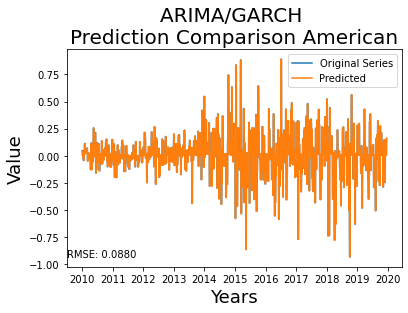

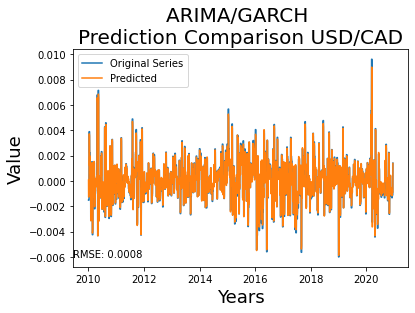

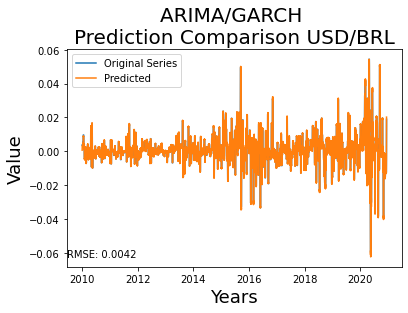


American Model Prediction Errors
  Error     Value
0    ME -0.000109
1   MAE  0.001213
2  RMSE  0.088034

USD/CAD Model Prediction Errors
  Error         Value
0    ME -2.967873e-07
1   MAE  1.090847e-04
2  RMSE  8.052409e-04

USD/BRL Model Prediction Errors
  Error     Value
0    ME -0.000037
1   MAE  0.000291
2  RMSE  0.004175


In [11]:
plot_2_series(real=train_American_diff1,
            model=pred_American,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(train_American_diff1,pred_American)),
            title='ARIMA/GARCH \nPrediction Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=train_USD_CAD_diff1,
            model=pred_CAD,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(train_USD_CAD_diff1,pred_CAD)),
            title='ARIMA/GARCH \nPrediction Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=train_USD_BRL_diff1,
            model=pred_BRL,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(train_USD_BRL_diff1,pred_BRL)),
            title='ARIMA/GARCH \nPrediction Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican Model Prediction Errors")
print(errors(train_American_diff1,pred_American))
print("\nUSD/CAD Model Prediction Errors")
print(errors(train_USD_CAD_diff1,pred_CAD))
print("\nUSD/BRL Model Prediction Errors")
print(errors(train_USD_BRL_diff1,pred_BRL))

## Forecasting


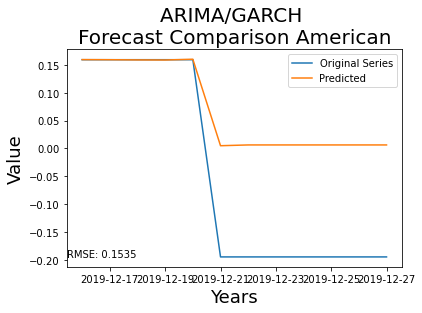

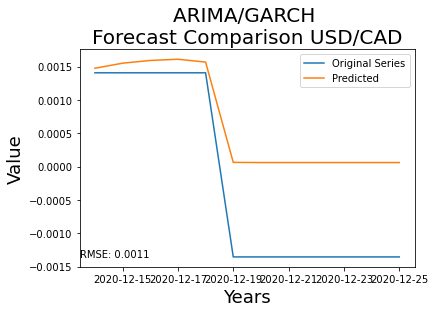

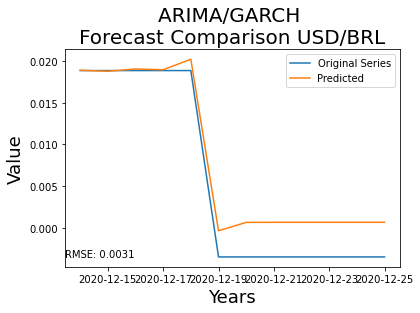


American Model Forecast Errors
  Error     Value
0    ME  0.117106
1   MAE  0.200360
2  RMSE  0.153410

USD/CAD Model Forecast Errors
  Error     Value
0    ME  0.000889
1   MAE  0.001415
2  RMSE  0.001086

USD/BRL Model Forecast Errors
  Error     Value
0    ME  0.002435
1   MAE  0.003606
2  RMSE  0.003070


In [12]:
#We use the ARIMA MODEL to predict the next 12 steps of each series
arima_for_American = arima_American_diff1.predict(start=test_American_diff1.index.astype(str)[0],end=test_American_diff1.index.astype(str)[-1])
arima_for_BRL = arima_USD_BRL_diff1.predict(start=test_USD_BRL_diff1.index.astype(str)[0],end=test_USD_BRL_diff1.index.astype(str)[-1])
arima_for_CAD = arima_USD_CAD_diff1.predict(start=test_USD_CAD_diff1.index.astype(str)[0],end=test_USD_CAD_diff1.index.astype(str)[-1])

#We use the ARCH MODEL to forecast the next 12 steps of each series variances
garch_for_American = garch_American_diff1.forecast(horizon=12)
garch_for_BRL = garch_USD_BRL_diff1.forecast(horizon=12)
garch_for_CAD = garch_USD_CAD_diff1.forecast(horizon=12)

for_American = arima_for_American.copy(deep=True)
for_BRL = arima_for_BRL.copy(deep=True)
for_CAD = arima_for_CAD.copy(deep=True)

#We sum the models forecasts
for i in range(12):
    for_American[i] += garch_for_American.mean.iloc[-1][i]
    for_BRL[i] += garch_for_BRL.mean.iloc[-1][i]
    for_CAD[i] += garch_for_CAD.mean.iloc[-1][i]


plot_2_series(real=test_American_diff1,
            model=for_American,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(test_American_diff1,for_American)),
            title='ARIMA/GARCH \nForecast Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=test_USD_CAD_diff1,
            model=for_CAD,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(test_USD_CAD_diff1,for_CAD)),
            title='ARIMA/GARCH \nForecast Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=test_USD_BRL_diff1,
            model=for_BRL,
            error_value = np.sqrt(sklearn.metrics.mean_squared_error(test_USD_BRL_diff1,for_BRL)),
            title='ARIMA/GARCH \nForecast Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican Model Forecast Errors")
print(errors(test_American_diff1,arima_for_American))
print("\nUSD/CAD Model Forecast Errors")
print(errors(test_USD_CAD_diff1,arima_for_CAD))
print("\nUSD/BRL Model Forecast Errors")
print(errors(test_USD_BRL_diff1,arima_for_BRL))

## Conclusion:

The **GARCH+ARIMA Model**, for 1 of the 3 series used, had bad forecast values predictions, with a RMSE bigger than 15%, while for the other 2 series the error was very low. Since this project aims to compare the forecast capacity of variour models, no more conclusion can be made now prior to train and evaluate the other models.